In [1]:
pip install beautifulsoup4 requests pandas

Note: you may need to restart the kernel to use updated packages.


In [7]:
import bs4
import pandas as pd
import requests

In [9]:
from time import sleep
from random import randint

In [10]:
#Set the pages & years 
pages = [str(i) for i in range(1,20)]
years_url = [str(i) for i in range(1990,2019)]

In [11]:
#Get page contents function
def get_page_contents(url):
    page = requests.get(url)
    return bs4.BeautifulSoup(page.text, "html.parser")

In [12]:
#Get movie titles and release years
def get_title_year(soup): 
    movies = soup.findAll('h3', class_='lister-item-header')
    titles = [movie.find('a').text for movie in movies]
    release = [movie.find('span', class_='lister-item-year text-muted unbold').text[-5:-1] for movie in movies]
   # bad_chars = ['(I) ']
    #final1=[]
    #for i in bad_chars:
     #   for j in release:
      #      j = j.replace(i,'').replace("(","").replace(")","")
       #     final1.append(j)
    DF=pd.DataFrame()
    DF['MovieTitle']=titles
    DF['ReleaseYear']=release
    return DF

In [13]:
#Function to get the IMDB rating
def get_rating(soup):
    movies1=soup.findAll('div', class_="ratings-bar")
    rating=[]
    for movie in movies1:
        rating.append(float(movie.find('div', 'inline-block ratings-imdb-rating')['data-value']))
    DF=pd.DataFrame()
    DF['Rating']=rating
    return DF

In [14]:
#Function to get the votes & earnings
def get_votes_earnings(soup):
    movies2=soup.findAll('p', class_='sort-num_votes-visible')
    num=[]
    votes=[]
    earnings=[]
    votes_available=1
    earnings_available=1
    i=0
    for movie in movies2:
        num.append(movie.findAll('span' , attrs = {'name' : 'nv'}))
        try:
            v=str(num[i][0])
        except:
            votes_available=0
        try:
            e=str(num[i][1])
        except:
            earnings_available=0
        if votes_available!=0: votes.append(v.split('"')[1])
        else: votes.append(None)
        if  earnings_available!=0: earnings.append(e.split('"')[1])
        else: earnings.append(None)
        i=i+1  
    DF=pd.DataFrame()
    DF['Votes']=votes
    DF['GrossEarnings']=earnings
    return DF

In [15]:
#Function to get the genre,runtime & certificate
def get_genre_runtime(soup):
    movies3=soup.findAll('p', class_='text-muted')
    genre=[]
    runtime=[]
    certificate=[]
    i=0
    a = [i for i in range(100)]
    for i in a:
        if i%2==0:
            a=(movies3[i].find('span' , class_='genre').text).lstrip()
            genre.append(str(a).strip())
            runtime.append(movies3[i].find('span' , class_='runtime').text)
            certificate.append(movies3[i].find('span' , class_='certificate').text)
    DF=pd.DataFrame()
    DF['Genre']=genre
    DF['RunTime']=runtime
    DF['Certificate']=certificate
    return DF

In [16]:
#Function to get the meta score of the movies
def get_metascore(soup):
    movies4=soup.findAll('div',class_='inline-block ratings-metascore')
    metascore=[]
    metascore_param=[]
    for movie in movies4:
        try:
            metascore.append(movie.find('span',class_='metascore favorable').text)
            metascore_param.append('Favorable')
        except:
            try:
                metascore.append(movie.find('span',class_='metascore mixed').text)
                metascore_param.append('Mixed')
            except:
                metascore.append(movie.find('span',class_='metascore unfavorable').text)
                metascore_param.append('Unfavorable')
    DF=pd.DataFrame()
    DF['Metascore_Value']=metascore
    DF['Metascore_Key']=metascore_param
    return DF

In [17]:
#Pull the data - web scraping
DF_Final=pd.DataFrame()
DF_new=pd.DataFrame()
for year_url in years_url:

    # For every page in the interval 1-4
    for page in pages:

        url='http://www.imdb.com/search/title?release_date=' + year_url + '&sort=num_votes,desc&page=' + page
        soup = get_page_contents(url)
        DF1=get_title_year(soup)
        DF2=get_genre_runtime(soup)
        DF3=get_rating(soup)
        DF4=get_votes_earnings(soup)
        DF5=get_metascore(soup)
        DF_new=pd.concat([DF1,DF2,DF3,DF4,DF5], axis=1, ignore_index=True)
        DF_Final=DF_Final.append(DF_new) 
        

In [18]:
#Check the data frame dimensions
DF_Final.shape

(27550, 10)

In [19]:
#Renaming the columns
DF_Final.columns = ['Title','ReleaseYear','Genre','Duration','Certificate','IMDB_Rating','Votes','GrossIncome','Metascore_Value','Metascore_Key']

In [20]:
#Checking the data types
DF_Final.dtypes

MovieTitle          object
ReleaseYear         object
Genre               object
Duration            object
Certificate         object
IMDB_Rating        float64
Votes               object
GrossIncome         object
Metascore_Value     object
Metascore_Key       object
dtype: object

In [87]:
#DF_Final=DF_Final.reset_index(drop=True)

In [21]:
#check some records
DF_Final.head()

,MovieTitle,ReleaseYear,Genre,Duration,Certificate,IMDB_Rating,Votes,GrossIncome,Metascore_Value,Metascore_Key
0,Goodfellas,1990,"Biography, Crime, Drama",146 min,R,8.7,961282,"46,836,394",90,Favorable
1,Home Alone,1990,"Comedy, Family",103 min,PG,7.6,442270,"285,761,243",63,Favorable
2,Edward Scissorhands,1990,"Drama, Fantasy, Romance",105 min,PG-13,7.9,429128,"56,362,352",74,Favorable
3,Back to the Future Part III,1990,"Adventure, Comedy, Sci-Fi",118 min,PG,7.4,380294,"87,727,583",55,Mixed
4,The Godfather: Part III,1990,"Crime, Drama",162 min,R,7.6,339644,"66,666,062",60,Mixed


In [22]:
#Filter the movie data - remove the drams's data
DF_IMDB=pd.DataFrame()
DF_IMDB=DF_Final[DF_Final['Certificate'].isin(['R','G','PG','PG-13','NC-17']) ]

In [28]:
#Check the final data frame dimensions
DF_IMDB.shape

(25308, 10)

In [24]:
#check some records
DF_IMDB.head()

,MovieTitle,ReleaseYear,Genre,Duration,Certificate,IMDB_Rating,Votes,GrossIncome,Metascore_Value,Metascore_Key
0,Goodfellas,1990,"Biography, Crime, Drama",146 min,R,8.7,961282,"46,836,394",90,Favorable
1,Home Alone,1990,"Comedy, Family",103 min,PG,7.6,442270,"285,761,243",63,Favorable
2,Edward Scissorhands,1990,"Drama, Fantasy, Romance",105 min,PG-13,7.9,429128,"56,362,352",74,Favorable
3,Back to the Future Part III,1990,"Adventure, Comedy, Sci-Fi",118 min,PG,7.4,380294,"87,727,583",55,Mixed
4,The Godfather: Part III,1990,"Crime, Drama",162 min,R,7.6,339644,"66,666,062",60,Mixed


In [25]:
#Drop duplicates if any
DF_Updated=DF_IMDB.drop_duplicates(subset=None, keep='first', inplace=False)
DF_Updated.shape

In [29]:
#Write the data into a csv file
DF_Updated.to_csv('IMDB_data_Updated.csv',index=False)

In [71]:
import pandas as pd

In [39]:
#Import the datasets
DF1=pd.read_csv('IMDB_data_Updated.csv')
DF1.shape

(1421, 10)

In [40]:
#Rename the columns(to keep the joining column name same)
DF1.columns = ['Title','ReleaseYear','Genre','Duration','Certificate','IMDB_Rating','Votes','GrossIncome','Metascore_Value','Metascore_Key']

In [43]:
#Convert Title data to lower case
DF1['Title'] = DF1['Title'].apply(lambda x: x.lower().strip())
DF1.head()

In [59]:
#Load the dataset with movie plots
DF2=pd.read_csv('wiki_movie_plots_deduped.csv')
DF2.shape

(34886, 8)

In [69]:
#Subset the required columns & drop the duplicates
Subset_DF2=DF2[['Title','Plot']]
Subset_DF2['Title'] = Subset_DF2['Title'].apply(lambda x: x.lower().strip())
DF2_updated=Subset_DF2.drop_duplicates(subset='Title', keep='first', inplace=False)
DF2_updated.head()

C:\Users\himaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [73]:
#Check the size of the data set after dropping the duplicates
DF2_updated.shape

(32341, 2)

In [72]:
#Join both the data sets
Final_DF=pd.merge(DF1,DF2_updated,on=['Title'],how='left')
Final_DF=Final_DF.drop_duplicates(subset=None, keep='first', inplace=False)
Final_DF.shape

(1421, 11)

In [ ]:
Final_DF.to_csv('IMDB_Final.csv',index = False)

In [1]:
import pandas as pd

In [75]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
Final_DF=pd.read_csv('IMDB_Final.csv')
Final_DF.shape

(1421, 11)

In [89]:
Model_DF=Final_DF[['Title','Plot']]

In [83]:
Genre_Dummies=Final_DF['Genre'].str.get_dummies(sep=', ')

In [64]:
def genre_func(DF,*args):
    DF1=[]
    for i in range(len(DF)):
        a=0
        for num in args:
            a=a or DF[num].iloc[i]
        DF1.append(a)  
    return DF1

In [90]:
DF1=genre_func(Genre_Dummies,'Action','War')
DF2=genre_func(Genre_Dummies,'Adventure','Western')
DF3=genre_func(Genre_Dummies,'Thriller','Mystery')
DF4=genre_func(Genre_Dummies,'Family','Drama')
DF5=genre_func(Genre_Dummies,'Music','Musical')
DF6=genre_func(Genre_Dummies,'Biography','History','Documentary')

In [91]:
Model_DF['Action']=DF1
Model_DF['Adventure']=DF2
Model_DF['Thriller']=DF3
Model_DF['Drama']=DF4
Model_DF['Musical']=DF5
Model_DF['History']=DF6

In [92]:
Model_DF['Comedy']=Genre_Dummies['Comedy']
Model_DF['Crime']=Genre_Dummies['Crime']
Model_DF['Animation']=Genre_Dummies['Animation']
Model_DF['Horror']=Genre_Dummies['Horror']
Model_DF['SciFi']=Genre_Dummies['Sci-Fi']
Model_DF['Romance']=Genre_Dummies['Romance']
Model_DF['Fantasy']=Genre_Dummies['Fantasy']
Model_DF['Sport']=Genre_Dummies['Sport']

In [93]:
Model_DF.shape

(1421, 16)

In [94]:
#Write the data into a csv file
Model_DF.to_csv('Model_DF.csv',index = False)

In [52]:
import plotly.graph_objects as go
import pandas as pd

In [53]:
import pandas as pd
import os
os.chdir(r"C:\Users\venka\Downloads")
Final_DF=pd.read_csv('IMDB_Final.csv')
Final_DF.shape

(1421, 11)

In [54]:
Final_DF.head()

,Title,ReleaseYear,Genre,Duration,Certificate,IMDB_Rating,Votes,GrossIncome,Metascore_Value,Metascore_Key,Plot
0,goodfellas,1990,"Biography, Crime, Drama",146 min,R,8.7,961282,"46,836,394",90.0,Favorable,"In 1955, Henry Hill works for Paul ""Paulie"" Ci..."
1,home alone,1990,"Comedy, Family",103 min,PG,7.6,442270,"285,761,243",63.0,Favorable,The McCallister family is preparing to spend C...
2,edward scissorhands,1990,"Drama, Fantasy, Romance",105 min,PG-13,7.9,429128,"56,362,352",74.0,Favorable,An elderly woman tells her granddaughter the s...
3,back to the future part iii,1990,"Adventure, Comedy, Sci-Fi",118 min,PG,7.4,380294,"87,727,583",55.0,Mixed,"On November 12, 1955, Marty McFly discovers th..."
4,the godfather: part iii,1990,"Crime, Drama",162 min,R,7.6,339644,"66,666,062",60.0,Mixed,NaN


In [55]:
Model_DF=Final_DF[['Title','Plot','ReleaseYear','IMDB_Rating','Metascore_Value','Metascore_Key','Genre']]
Model_DF.head()

,Title,Plot,ReleaseYear,IMDB_Rating,Metascore_Value,Metascore_Key,Genre
0,goodfellas,"In 1955, Henry Hill works for Paul ""Paulie"" Ci...",1990,8.7,90.0,Favorable,"Biography, Crime, Drama"
1,home alone,The McCallister family is preparing to spend C...,1990,7.6,63.0,Favorable,"Comedy, Family"
2,edward scissorhands,An elderly woman tells her granddaughter the s...,1990,7.9,74.0,Favorable,"Drama, Fantasy, Romance"
3,back to the future part iii,"On November 12, 1955, Marty McFly discovers th...",1990,7.4,55.0,Mixed,"Adventure, Comedy, Sci-Fi"
4,the godfather: part iii,NaN,1990,7.6,60.0,Mixed,"Crime, Drama"


In [56]:
Model_DF.columns

Index(['Title', 'Plot', 'ReleaseYear', 'IMDB_Rating', 'Metascore_Value',
       'Metascore_Key', 'Genre'],
      dtype='object')

In [57]:
Model_DF.ReleaseYear.unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018], dtype=int64)

In [58]:
Model_DF.dtypes

Title               object
Plot                object
ReleaseYear          int64
IMDB_Rating        float64
Metascore_Value    float64
Metascore_Key       object
Genre               object
dtype: object

In [59]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

In [60]:
#Splitting of Genres to create additional rows
Model_DF_Temp = Model_DF.drop('Genre', axis=1).join(
  Model_DF['Genre'].str.split(',', expand=True).stack().reset_index(level=1,drop=True).rename('Genre'))
Model_DF_Temp.head()

,Title,Plot,ReleaseYear,IMDB_Rating,Metascore_Value,Metascore_Key,Genre
0,goodfellas,"In 1955, Henry Hill works for Paul ""Paulie"" Ci...",1990,8.7,90.0,Favorable,Biography
0,goodfellas,"In 1955, Henry Hill works for Paul ""Paulie"" Ci...",1990,8.7,90.0,Favorable,Crime
0,goodfellas,"In 1955, Henry Hill works for Paul ""Paulie"" Ci...",1990,8.7,90.0,Favorable,Drama
1,home alone,The McCallister family is preparing to spend C...,1990,7.6,63.0,Favorable,Comedy
1,home alone,The McCallister family is preparing to spend C...,1990,7.6,63.0,Favorable,Family


In [61]:
#Plotting Number Of Movies Released Every Year By Genre
fig = px.bar(Model_DF_Temp, x='ReleaseYear',y='Genre',color='Genre')
fig.update_layout(title_text='Movie Count by Genre')
fig.show()

In [62]:
#Plotting The Critic Ratings By Genre
Model_DF2 = Model_DF_Temp.groupby('Genre')['IMDB_Rating'].mean()
Model_DF2=Model_DF2.reset_index()
fig = px.bar(Model_DF2, x='Genre', y='IMDB_Rating',color='IMDB_Rating')
fig.update_layout(title_text='Critic Ratings by Genre')
fig.show()

In [63]:
#Plotting the Metascore By Genre and Metascore Key
Model_DF5 = Model_DF_Temp.groupby(['Genre','Metascore_Key'])['Metascore_Value'].mean()
Model_DF5=Model_DF5.reset_index()
fig = px.line(Model_DF5, x='Genre', y='Metascore_Value',color='Metascore_Key')
fig.update_layout(title_text='Audience Ratings by Genre')
fig.show()

In [66]:
#Plotting The Critics Rating By Year
Model_DF4 = Model_DF_Temp.groupby('ReleaseYear')['IMDB_Rating'].mean()
Model_DF4=Model_DF4.reset_index()
fig = px.line(Model_DF4, x='ReleaseYear', y='IMDB_Rating')
fig.update_layout(title_text='Movie Quality By Year')
fig.show()

In [64]:
#Plotting The Metascore Ratings By Year
Model_DF3 = Model_DF_Temp.groupby('ReleaseYear')['Metascore_Value'].mean()
Model_DF3=Model_DF3.reset_index()
fig = px.line(Model_DF3, x='ReleaseYear', y='Metascore_Value')
fig.update_layout(title_text='Audience Rating By Year')
fig.show()

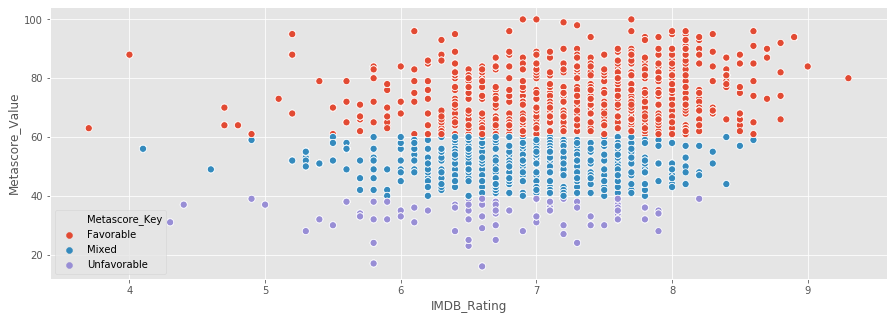

In [65]:
#Finding The Correlation Between Metascore_Value and IMDB_Rating
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.style.use('ggplot')

plt.figure(figsize=(15,5))
sns.scatterplot(x="IMDB_Rating", y="Metascore_Value", hue="Metascore_Key", s = 50,
                     data=Model_DF_Temp);

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import sys

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\himaj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\himaj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [4]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [5]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

In [17]:
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report

In [8]:
#Load the data to a data frame from the csv file with dummy genre variables and title,plot
Model_DF=pd.read_csv('Model_DF.csv')

In [9]:
Model_DF.columns

Index(['Title', 'Plot', 'Action', 'Adventure', 'Thriller', 'Drama', 'Musical',
       'History', 'Comedy', 'Crime', 'Animation', 'Horror', 'SciFi', 'Romance',
       'Fantasy', 'Sport'],
      dtype='object')

In [ ]:
#Plot the most frequent words in the plots

In [10]:
#split the plots into words
plot = Model_DF['Plot'].str.cat(sep=' ').lower().strip()

In [11]:
#identify the frequent words
tokens = word_tokenize(plot)
vocabulary = set(tokens)
print(len(vocabulary))
frequency_dist = nltk.FreqDist(tokens)

35122


In [12]:
#Remove the punctuations from the words list
tokens = [word for word in tokens if word.isalpha()]
vocabulary = set(tokens)
print(len(vocabulary))
frequency_dist = nltk.FreqDist(tokens)

31492


In [13]:
#Further clean up the text by removing the stopwords
stop_words = set(stopwords.words('english'))
tokens = [w for w in tokens if not w in stop_words]
vocabulary = set(tokens)
print(len(vocabulary))
frequency_dist = nltk.FreqDist(tokens)

31358


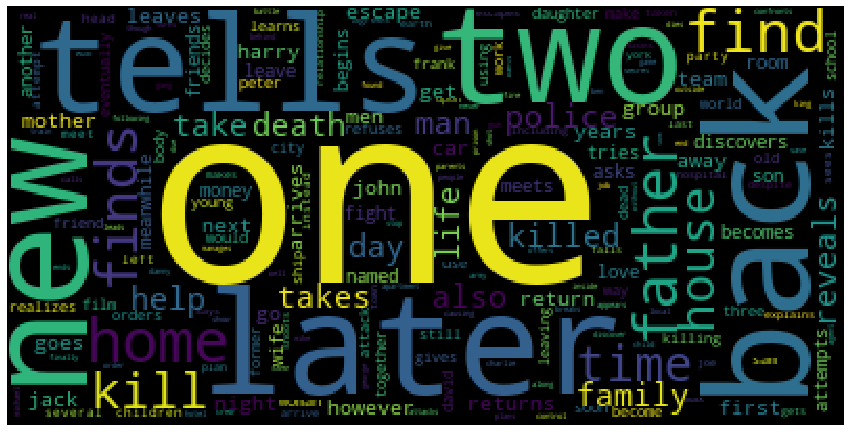

In [14]:
#Plot the frequent words
wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [15]:
#List of models to be used for the text analysis
models = {
    "SVC": svm.SVC(kernel="linear"),
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "BaggingClassifier": BaggingClassifier(),
    "ExtraTreesClassifier": ExtraTreesClassifier()
}

In [33]:
#Train and evaluate the models for all identified genre's
X= Model_DF.Plot.fillna(' ')
accuracy=[]
model_used=[]
genre_column=[]
for col in Model_DF.columns:
    if col!='Plot' and col!='Title':
        y= Model_DF[col]
        xtrain,xtest,ytrain,ytest=train_test_split(X,y,test_size = 0.25,random_state=1905)
        vect = CountVectorizer()
        X_train_df = vect.fit_transform(xtrain)
        X_test_df = vect.transform(xtest)
        prediction = dict()
        score_map = {}
        max_score=0
        most_accurate_model=''
        for model_name in models:
            model = models[model_name]
            model.fit(X_train_df,ytrain)
            prediction[model_name] = model.predict(X_test_df)
            score = accuracy_score(ytest, prediction[model_name])
            score_map[model_name] = score
            if score>max_score:
                max_score=score
                most_accurate_model=model_name
        accuracy.append(max_score)
        model_used.append(most_accurate_model)
        genre_column.append(col)
DF=pd.DataFrame()
DF['Model']=model_used
DF['AccuracyScore']=accuracy
DF['Genre']=genre_column      

In [34]:
#Display the most accurate models for all genres
DF

,Model,AccuracyScore,Genre
0,MultinomialNB,0.817416,Action
1,MultinomialNB,0.837079,Adventure
2,LogisticRegression,0.800562,Thriller
3,BaggingClassifier,0.710674,Drama
4,SVC,0.980337,Musical
5,MultinomialNB,0.915730,History
6,MultinomialNB,0.786517,Comedy
7,MultinomialNB,0.853933,Crime
8,SVC,0.969101,Animation
9,SVC,0.941011,Horror


In [64]:
#Set the new data to predict 
new_df1=Model_DF.sample(n=10)
new_df=new_df1[['Title','Plot']]
predict_df=new_df.Plot.fillna(' ')

In [65]:
#Predict the genre for new plots - To test the code, we randomly picked 10 records from the original dataset
prediction=pd.DataFrame()
prediction['Title']=new_df['Title']
DF_predicted=pd.DataFrame()
for row in range(len(DF)):
    col=DF['Genre'].iloc[row]
    y= Model_DF[col]
    xtrain,xtest,ytrain,ytest=train_test_split(X,y,test_size = 0.25,random_state=1905)
    vect = CountVectorizer()
    X_train_df = vect.fit_transform(xtrain)
    output = vect.transform(predict_df)
    model_name=DF['Model'].iloc[row]
    model.fit(X_train_df,ytrain)
    prediction[col] = model.predict(output)
    

In [66]:
#Append Genre to the new plots dataset
Genre=[]
for i in range(len(prediction)):
    a=prediction.columns[(prediction == 1).iloc[i]].tolist()
    start = str(a).find("[")
    end = str(a).find("]")
    substr = str(a)[start+1:end]
    Genre.append(substr)
new_df['Genre']=Genre

In [67]:
#Display the results
new_df

,Title,Plot,Genre
824,disturbia,Troubled by the death of his father (Matt Crav...,"'Drama', 'Comedy'"
1034,argo,"On November 4, 1979, Iranian activists storm t...","'Thriller', 'Drama', 'History'"
273,get shorty,"Chili Palmer, a loan shark based in Miami, cla...","'Thriller', 'Comedy', 'Crime'"
134,forever young,"In 1939, Captain Daniel McCormick (Mel Gibson)...",'Drama'
1104,elysium,"In 2154, Earth is overpopulated and polluted. ...","'Action', 'Drama', 'SciFi'"
30,look who's talking too,The movie picks up with the now married Mollie...,"'Drama', 'Comedy', 'Romance'"
965,blue valentine,The film is presented in a nonlinear narrative...,"'Drama', 'Romance'"
877,revolutionary road,"In 1948, Frank Wheeler (DiCaprio) meets April ...","'Drama', 'Romance'"
492,what women want,Nick Marshall is a Chicago advertising executi...,"'Comedy', 'Romance', 'Fantasy'"
427,star wars: episode i - the phantom menace,NaN,
